In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.2 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio
from tensorflow.keras.initializers import he_normal
import datetime
import pandas as pd
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from PIL import Image
import glob
from sklearn.cluster import KMeans
import tensorflow_addons as tfa
import pickle

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
batch_size = 64
num_channels = 1
image_size = 128
latent_dim = 128
num_features = 1
root = '/content/drive/MyDrive/CancerCell/'

In [ ]:
#!unzip '/content/drive/MyDrive/Hossein/Dataset_Images_C_H_FeatureFile-20230807T162523Z-001' -d '/content/drive/MyDrive/Hossein/Dataset_Aug7_v2/'
#!find '/content/drive/MyDrive/Hossein/Dataset_Aug7_v2/Dataset_Images_C_H_FeatureFile/' -type f | wc -l

In [ ]:
# !find '/content/drive/MyDrive/Hossein/Dataset_Aug7_v2/Dataset_Images_C_H_FeatureFile/' -type f | wc -l

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/features_Day0_C_Day5_H_030405_July21_FileNames.csv')
data = df.iloc[:,5:].values
data = StandardScaler().fit_transform(data)

In [ ]:
data.shape

(15266, 123)

In [ ]:
df['FileName']= 'Well'+df['Metadata_Well'].astype(str)+'_'+df['Metadata_Fr'].astype(str)+'_'+df['ObjectNumber'].astype(str)+'.png'

In [ ]:
kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=2,
                    max_iter=10000,
                    random_state=1,
                    verbose=0).fit(data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [ ]:
filename = root + "kmeans.pickle"

# save model
#pickle.dump(model, open(kmeans, "wb"))
pickle.dump(kmeans, open(filename, "wb"))

# load model
# loaded_model = pickle.load(open(filename, "rb"))

In [ ]:
# df['cluster'] = (kmeans.labels_ - 2 )/ 2
df['cluster'] = kmeans.labels_ - 0.5

In [ ]:
img_files = glob.glob('/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/*.png')
print(len(img_files))
print(img_files)

15266
['/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellC05_7_161.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellC04_5_212.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellC05_7_415.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellC04_5_44.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellC04_5_84.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellC05_7_159.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellH04_0_17.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellH04_0_70.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellC04_5_360.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellC05_7_174.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/WellH04_0_90.png', '/content/drive/MyDrive/CancerCell/Dataset_Images_C_

In [ ]:
df['FileName'] = '/content/drive/MyDrive/CancerCell/Dataset_Images_C_H_FeatureFile/'+df['FileName']

In [ ]:
df = df[df['FileName'].isin(img_files)]
print(len(df))

15266


In [ ]:
def map_fn(path, c):
    image = tf.image.decode_png(tf.io.read_file(path),channels=1)
    #image = tfa.image.equalize(image)
    image = tf.image.resize_with_crop_or_pad(image, target_height=image_size,target_width=image_size)
    image = (tf.cast(image, tf.float32)-127.5) / 127.5
    return image, c

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((df['FileName'].values, df['cluster'].values.astype('float32').reshape(-1,1)))
dataset = dataset.map(map_fn)
dataset = (dataset
    .shuffle(1024)
    .cache()
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

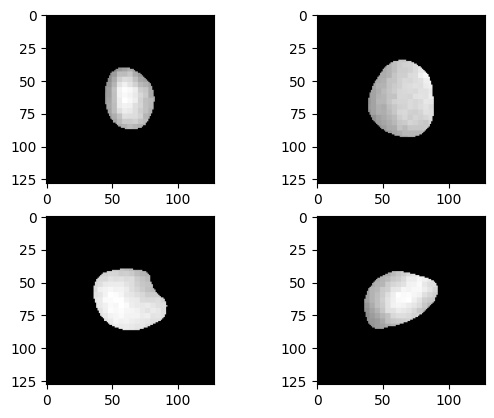

In [ ]:
for x, y in dataset.take(1):
  x = np.clip(x, -1 ,1)
  x = x * 0.5 + 0.5
  x *= 255.0
  x = x.astype(np.uint8)
  for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(x[i], cmap='gray')
  plt.show()

In [ ]:
generator_in_channels = latent_dim + num_features
discriminator_in_channels = num_channels + num_features
print(generator_in_channels, discriminator_in_channels)

129 2


In [ ]:
def get_discriminator():
  input_layer = layers.Input(shape=(image_size,image_size,num_channels+1))
  x = layers.Conv2D(32 , (7,7) , padding='same',strides=2,use_bias=True)(input_layer)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2D(64 , (7,7) , padding='same',strides=2,use_bias=True)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2D(128 , (7,7) , padding='same',strides=2,use_bias=True)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2D(256 , (7,7) , padding='same',strides=2,use_bias=True)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(256 , activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1)(x)
  model = tf.keras.models.Model(input_layer,x, name='discriminator')
  print(model.summary())
  return model

In [ ]:
def get_geneator():
  input_layer = layers.Input(shape=(latent_dim+num_features))
  x = layers.Dense(8 * 8 * (latent_dim+num_features))(input_layer)
  # x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Reshape((8, 8, latent_dim+num_features))(x)
  x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same",use_bias=True)(x)
  # x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same",use_bias=True)(x)
  # x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same",use_bias=True)(x)
  # x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2DTranspose(num_channels, (5, 5), strides=(2, 2), padding="same",use_bias=True)(x)
  # x = layers.BatchNormalization()(x)
  x = layers.Activation("tanh")(x)
  model = tf.keras.models.Model(input_layer,x, name='generator')
  print(model.summary())
  return model


In [ ]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim,batch_size):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.batch_size = batch_size
        self.d_steps = 3
        self.gp_weight = 10

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
        # return [self.gen_loss_tracker, tf.keras.metrics.Accuracy()]

    def compile(self, d_optimizer, g_optimizer, d_loss_fn,g_loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        # Unpack the data.
        real_images, features = data

        for i in range(self.d_steps):
            image_of_features = tf.repeat(
                      features, repeats=[image_size * image_size] ,axis=1
                  )
            image_of_features = tf.reshape(
                image_of_features, (-1, image_size, image_size, 1)
            )
            batch_size = tf.shape(real_images)[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            random_vector_features = tf.concat(
                [random_latent_vectors, features], axis=1
            )

            with tf.GradientTape() as tape:
                self.discriminator.trainable = True
                # Generate fake images from the latent vector
                fake_images = self.generator(random_vector_features,training=True)
                fake_image_and_features = tf.concat([fake_images, image_of_features], -1)
                real_image_and_features = tf.concat([real_images, image_of_features], -1)

                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_image_and_features, training=True)

                # Get the logits for the real images
                real_logits = self.discriminator(real_image_and_features, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_image_and_features, fake_image_and_features)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )


        # Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_features = tf.concat(
                [random_latent_vectors, features], axis=1
            )

        with tf.GradientTape() as g_tape:
            self.discriminator.trainable = False

            g_tape.watch(self.generator.trainable_variables)

            # Generate fake images using the generator
            generated_images = self.generator(random_vector_features, training=True)
            # Get the discriminator logits for fake images
            fake_image_and_features = tf.concat([generated_images, image_of_features], -1)
            gen_img_logits = self.discriminator(fake_image_and_features, training=True)

            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = g_tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )



        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {"d_loss": d_loss, "g_loss": g_loss}


In [ ]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [ ]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=128, feature=[]):
        self.latent_dim = latent_dim
        self.feature = feature

    def on_epoch_end(self, epoch, logs=None):
        # Sample noise for the interpolation.
        _noise = tf.random.normal(shape=(len(self.feature), latent_dim))
        labels = np.array(self.feature).reshape((len(self.feature),num_features))

        # Combine the noise and the labels and run inference with the generator.
        _noise_and_labels = tf.concat([_noise, labels], 1)
        fake_images = self.model.generator.predict(_noise_and_labels)
        fake_images = np.clip(fake_images, -1 ,1)
        # print(np.mean(fake_images))
        # print(np.std(fake_images))
        fake_images = fake_images * 0.5 + 0.5
        fake_images *= 255.0
        converted_images = fake_images.astype(np.uint8)
        # converted_images = tf.image.resize(converted_images, (256, 256)).numpy().astype(np.uint8)


        for i in range(len(self.feature)):
          # plt.subplot(2,2,i+1)
          # plt.imshow(converted_images[i], cmap='gray')
    #     plt.imsave(root+'result/epoch {}_{}.png'.format(epoch,i),converted_images[i])
          plt.imsave(root+'result/epoch {}_{}.png'.format(epoch,i),converted_images[i,:,:,0], cmap='gray')

        plt.show()

        if epoch % 50 == 0 :
           self.model.generator.save(root + 'GE W-cGAN Generator.h5')
           self.model.discriminator.save(root + 'GE W-cGAN Discriminator.h5')


In [ ]:
callback = GANMonitor(latent_dim=latent_dim,feature = [0-.5,1-.5])

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=get_discriminator(),
    generator=get_geneator(),
    latent_dim=latent_dim ,
    batch_size=batch_size
)
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9),
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

hist=cond_gan.fit(dataset, epochs=3000 , callbacks=[callback])

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        3168      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        100416    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       401536    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)     

239/239 [==============================] - 186s 679ms/step - d_loss: -332.0788 - g_loss: 3.6093
Epoch 2/3000
239/239 [==============================] - 156s 652ms/step - d_loss: -145.2057 - g_loss: 65.6696
Epoch 3/3000
239/239 [==============================] - 155s 650ms/step - d_loss: -122.5094 - g_loss: 59.8414
Epoch 4/3000
239/239 [==============================] - 159s 666ms/step - d_loss: -92.5659 - g_loss: -13.7847
Epoch 5/3000
239/239 [==============================] - 159s 666ms/step - d_loss: -56.6844 - g_loss: -48.2593
Epoch 6/3000
239/239 [==============================] - 160s 668ms/step - d_loss: -30.8960 - g_loss: -35.3529
Epoch 7/3000
239/239 [==============================] - 155s 650ms/step - d_loss: -20.1375 - g_loss: -4.8989
Epoch 8/3000
239/239 [==============================] - 159s 664ms/step - d_loss: -16.5144 - g_loss: -15.3529
Epoch 9/3000
239/239 [==============================] - 155s 649ms/step - d_loss: -13.9547 - g_loss: -23.9477
Epoch 10/3000
239/239 [==

239/239 [==============================] - 160s 670ms/step - d_loss: -7.7943 - g_loss: -31.5355
Epoch 52/3000
239/239 [==============================] - 156s 651ms/step - d_loss: -7.0095 - g_loss: -31.9232
Epoch 53/3000
239/239 [==============================] - 154s 646ms/step - d_loss: -6.6950 - g_loss: -38.8686
Epoch 54/3000
239/239 [==============================] - 154s 646ms/step - d_loss: -6.7750 - g_loss: -35.2449
Epoch 55/3000
239/239 [==============================] - 159s 664ms/step - d_loss: -6.7829 - g_loss: -30.5284
Epoch 56/3000
239/239 [==============================] - 159s 664ms/step - d_loss: -6.2972 - g_loss: -32.1752
Epoch 57/3000
239/239 [==============================] - 159s 664ms/step - d_loss: -6.6898 - g_loss: -19.1817
Epoch 58/3000
239/239 [==============================] - 158s 663ms/step - d_loss: -6.4057 - g_loss: -24.7103
Epoch 59/3000
239/239 [==============================] - 155s 649ms/step - d_loss: -6.3297 - g_loss: -28.8929
Epoch 60/3000
239/239 [=